# Imports

In [1]:
from pathlib import Path
import pickle
import math
import numpy as np
from tqdm import trange
from flygym.preprogrammed import all_leg_dofs
from flygym.util import get_data_path
from flygym import Fly, Camera
from flygym.arena import base as ba
from flygym.examples import turning_controller as tc
import matplotlib.pyplot as plt
from flygym.preprogrammed import get_collision_geometries
from IPython.display import Video
from gymnasium.utils.env_checker import check_env
from dm_control.rl.control import PhysicsError

# Data Paths

In [2]:
save_dir = Path("outputs")
save_dir.mkdir(exist_ok=True) 

data_path = get_data_path("flygym", "data")
with open(data_path / "behavior" / "210902_pr_fly1.pkl", "rb") as f:
    data = pickle.load(f)

# Simulation

### Simulation Parameters & Creation

In [ ]:
floor_contacts = get_collision_geometries("legs")
floor_contacts += ["LArista", "RArista", "Head"]

In [ ]:
run_time = 1.0
timestep = 1e-4
actuated_joints = all_leg_dofs
contact_sensor_placements = ["LArista", "RArista"]
contact_sensor_placements += [
    f"{leg}{segment}"
    for leg in ["LF", "LM", "LH", "RF", "RM", "RH"]
    for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
]

np.random.seed(0)

# Initialize fly
fly = Fly(
    enable_adhesion=True,
    spawn_pos=(5, 0, 0.5),
    actuated_joints=actuated_joints,
    contact_sensor_placements=contact_sensor_placements,
    draw_adhesion=True,
    floor_collisions=floor_contacts,
)

# Initialize cameras
cameras = [
    Camera(fly=fly, camera_id=f"Animat/camera_{side}", play_speed=0.15)
    for side in ["left", "front_zoomin", "top", "front", "head_zoomin", "left_top_zoomout", "front_zoomout_long", "neck_zoomin"]
]

arena = ba.ObstacleArenaGrp7()

fly._define_observation_space(arena)

sim = tc.HybridTurningNMF(
    fly=fly,
    cameras=cameras,
    timestep=timestep,
    seed=0,
    draw_corrections=False,
    arena=arena,
)
check_env(sim)

obs_list = []

obs, info = sim.reset(0)
print(f"Spawning fly at {obs['fly'][0]} mm")

c:\Users\Daniel Elmaleh\anaconda3\envs\flygymv1\Lib\site-packages\gymnasium\utils\env_checker.py:247: UserWarning: WARN: For Box action spaces, we recommend using a symmetric and normalized space (range=[-1, 1] or [0, 1]). See https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html for more information.
  logger.warn(
c:\Users\Daniel Elmaleh\anaconda3\envs\flygymv1\Lib\site-packages\gymnasium\utils\env_checker.py:225: UserWarning: WARN: A Box observation space minimum value is -infinity. This is probably too low.
  logger.warn(
c:\Users\Daniel Elmaleh\anaconda3\envs\flygymv1\Lib\site-packages\gymnasium\utils\env_checker.py:229: UserWarning: WARN: A Box observation space maximum value is -infinity. This is probably too high.
  logger.warn(


Spawning fly at [5.0163493  0.00730949 1.7814164 ] mm


c:\Users\Daniel Elmaleh\anaconda3\envs\flygymv1\Lib\site-packages\gymnasium\utils\env_checker.py:321: UserWarning: WARN: Not able to test alternative render modes due to the environment not having a spec. Try instantialising the environment through gymnasium.make
  logger.warn(


### Simulation Execution

In [ ]:
# Initialization
a, b, c, d = 0, 0, 0, 0
delay_after_col = 3500
force_threshold = 10  # Ensuring positive threshold
delay = delay_after_col
images_temp = []

images_temp.append(sim.render())

# Loop through simulation steps
for i in range(int(run_time / sim.timestep)):
    curr_time = i * sim.timestep

    # Initialize action to a default value
    action = np.array([1.0, 1.0])

    try:
        obs, reward, terminated, truncated, info = sim.step(action)
        obs_list.append(obs)
        images = sim.render()  # Updated rendering inside loop
    except PhysicsError:
        print("Simulation was interrupted because of a physics error")
        break

    # Calculate contact forces
    con_force_LArista = math.sqrt(obs["contact_forces"][0][0]**2 + obs["contact_forces"][0][1]**2 + obs["contact_forces"][0][2]**2)
    con_force_RArista = math.sqrt(obs["contact_forces"][1][0]**2 + obs["contact_forces"][1][1]**2 + obs["contact_forces"][1][2]**2)

    if ((con_force_LArista > force_threshold or con_force_RArista > force_threshold) and (not sim.backward_walking)):
        a += 1
        sim.backward_walking = True
        sim.intrinsic_freqs *= -1
        delay -= 1  # Reset delay on backward walking activation
        print("Backward Walking!")

    if (sim.backward_walking and delay < delay_after_col and delay > 0):
        b += 1
        delay -= 1

        if con_force_RArista > con_force_LArista:
            c += 1
            # Right Collision detected
            sim.fly.change_segment_color(sim.physics, "RArista", (1, 0, 0, 0.5))
            action = np.array([1.2, 0.4])
            images_temp.append(images)

        if con_force_LArista > con_force_RArista:
            d += 1
            # Left Collision detected
            sim.fly.change_segment_color(sim.physics, "LArista", (1, 0, 0, 0.5))
            action = np.array([0.4, 1.2])
            images_temp.append(images)
    elif (delay == 0):
        sim.backward_walking = False
        sim.intrinsic_freqs *= -1
        delay = delay_after_col
        action = np.array([1.0, 1.0])
        sim.fly.change_segment_color(sim.physics, "LArista", (1, 1, 1, 0.5))
        sim.fly.change_segment_color(sim.physics, "RArista", (1, 1, 1, 0.5))
    else:
        sim.backward_walking = False
        delay = delay_after_col
        action = np.array([1.0, 1.0])
        sim.fly.change_segment_color(sim.physics, "LArista", (1, 1, 1, 0.5))
        sim.fly.change_segment_color(sim.physics, "RArista", (1, 1, 1, 0.5))


Backward Walking!


In [ ]:
print("a: ", a)
print("b: ", b)
print("c: ", c)
print("d: ", d)

a:  1
b:  3499
c:  40
d:  0


# Plots

### Images

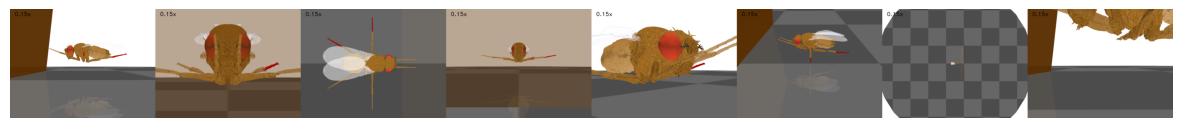

In [ ]:
plt.figure(figsize=(15, 15))
plt.imshow(np.concatenate(images_temp[0], axis=1))
plt.axis("off")
plt.show()


### Videos

In [ ]:
cameras[0].save_video("./outputs/video1.mp4", 0)
cameras[1].save_video("./outputs/video2.mp4", 0)
cameras[2].save_video("./outputs/video3.mp4", 0)
cameras[3].save_video("./outputs/video4.mp4", 0)
cameras[4].save_video("./outputs/video5.mp4", 0)
cameras[5].save_video("./outputs/video6.mp4", 0)
cameras[6].save_video("./outputs/video7.mp4", 0)
cameras[7].save_video("./outputs/video8.mp4", 0)

In [ ]:
Video(str("./outputs/video7.mp4"))

In [ ]:
Video(str("./outputs/video6.mp4"))

In [ ]:
Video(str("./outputs/video5.mp4"))

In [ ]:
Video(str("./outputs/video4.mp4"))

In [ ]:
Video(str("./outputs/video3.mp4"))

In [ ]:
Video(str("./outputs/video2.mp4"))

In [ ]:
Video(str("./outputs/video1.mp4"))

### Graphs

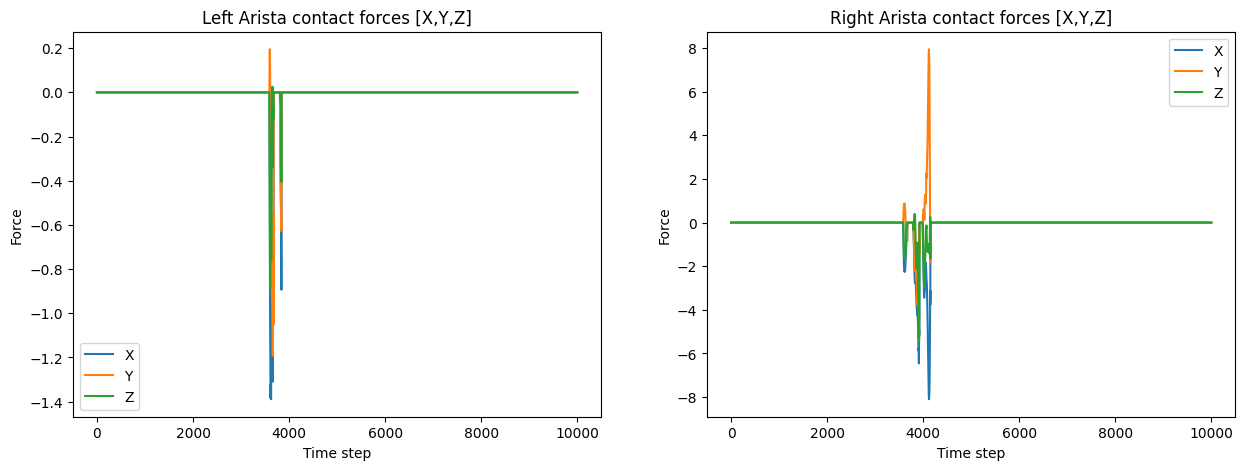

In [ ]:
tl_x =[]
tl_y =[]
tl_z =[]
tr_x =[]
tr_y =[]
tr_z =[]
for i in range(len(obs_list)):
    tl_x.append(obs_list[i]["contact_forces"][0][0])
    tl_y.append(obs_list[i]["contact_forces"][0][1])
    tl_z.append(obs_list[i]["contact_forces"][0][2])
    tr_x.append(obs_list[i]["contact_forces"][1][0])
    tr_y.append(obs_list[i]["contact_forces"][1][1])
    tr_z.append(obs_list[i]["contact_forces"][1][2])
# sub plots for left and right
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(tl_x, label='X')
plt.plot(tl_y, label='Y')
plt.plot(tl_z, label='Z')
plt.title('Left Arista contact forces [X,Y,Z]')
plt.xlabel('Time step')
plt.ylabel('Force')
plt.legend(['X', 'Y', 'Z'])
plt.subplot(1, 2, 2)
plt.plot(tr_x, label='X')
plt.plot(tr_y, label='Y')
plt.plot(tr_z, label='Z')
plt.title('Right Arista contact forces [X,Y,Z]')
plt.xlabel('Time step')
plt.ylabel('Force')
plt.legend(['X', 'Y', 'Z'])
plt.show()

Simulation step:  4110 Right Arista contact force:  10.085326128516314
Simulation step:  4111 Right Arista contact force:  10.274566306259985
Simulation step:  4112 Right Arista contact force:  10.462397871259887
Simulation step:  4113 Right Arista contact force:  10.638434567611842
Simulation step:  4114 Right Arista contact force:  10.800100056806158
Simulation step:  4115 Right Arista contact force:  10.942657825286949
Simulation step:  4116 Right Arista contact force:  11.068645214122371
Simulation step:  4117 Right Arista contact force:  11.178915085056703
Simulation step:  4118 Right Arista contact force:  11.273024333436727
Simulation step:  4119 Right Arista contact force:  11.348570133917871
Simulation step:  4120 Right Arista contact force:  11.398404556819917
Simulation step:  4121 Right Arista contact force:  11.389092960261854
Simulation step:  4122 Right Arista contact force:  11.30679400389533
Simulation step:  4123 Right Arista contact force:  11.231066585948623
Simulat

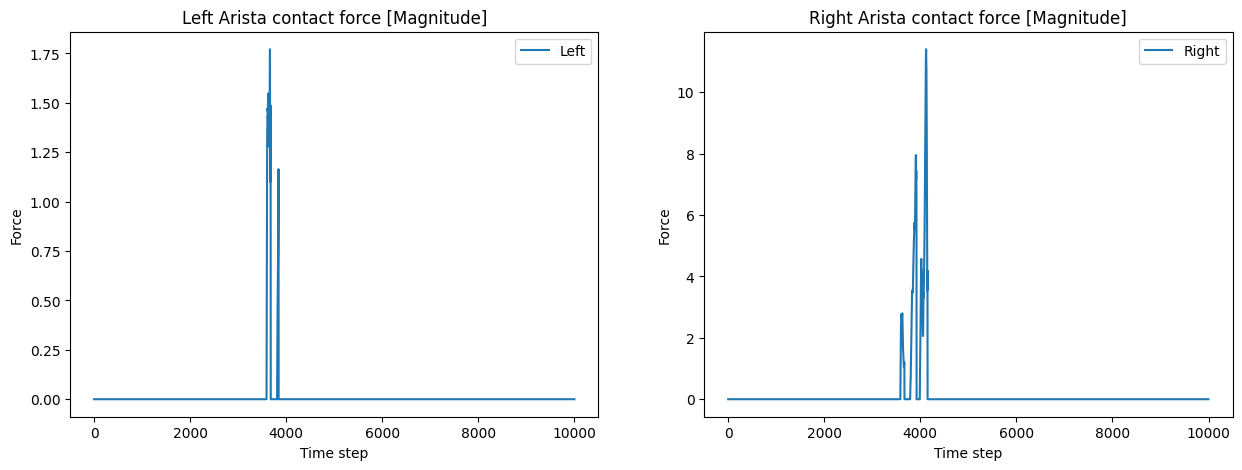

In [ ]:
kl =[]
kr =[]  
for i in range(len(obs_list)):
    kl.append(math.sqrt(obs_list[i]["contact_forces"][0][0] ** 2 + obs_list[i]["contact_forces"][0][1] ** 2 + obs_list[i]["contact_forces"][0][2] ** 2))
    if kl[i] > 10:
        print("Simulation step: ", i, "Left Arista contact force: ", kl[i])
    kr.append(math.sqrt(obs_list[i]["contact_forces"][1][0] ** 2 + obs_list[i]["contact_forces"][1][1] ** 2 + obs_list[i]["contact_forces"][1][2] ** 2))
    if kr[i] > 10:
        print("Simulation step: ", i, "Right Arista contact force: ", kr[i])

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(kl, label='Left')
plt.title('Left Arista contact force [Magnitude]')
plt.xlabel('Time step')
plt.ylabel('Force')
plt.legend(['Left'])
plt.subplot(1, 2, 2)
plt.plot(kr, label='Right')
plt.title('Right Arista contact force [Magnitude]')
plt.xlabel('Time step')
plt.ylabel('Force')
plt.legend(['Right'])
plt.show()